In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

C:\Users\green\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\green\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [5]:
sample = 10123

sample_csv = pd.read_csv('./sample/sample_data/10000/10000.csv')
sample_image = cv2.imread('./sample/sample_data/10000/10000.jpg')
sample_json = json.load(open('./sample/sample_data/10000/10000.json', 'r'))

In [6]:
# csv
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-07-14 10:10:00,31.7,32.0,31.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,302.6,-,-
1,2021-07-14 10:00:00,31.2,31.3,30.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,260.8,-,-
2,2021-07-14 09:50:00,31.4,31.4,31.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,196.3,-,-
3,2021-07-14 09:40:00,31.3,31.4,31.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,333.5,-,-
4,2021-07-14 09:30:00,30.7,31.0,30.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,663.5,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2021-07-12 10:00:00,30.6,30.6,30.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,179.0,-,-
287,2021-07-12 09:50:00,30.3,30.4,30.2,-,-,-,-,-,-,...,-,-,-,-,-,-,-,180.4,-,-
288,2021-07-12 09:40:00,30.0,30.1,29.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,232.5,-,-
289,2021-07-12 09:30:00,29.5,29.6,29.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,546.6,-,-


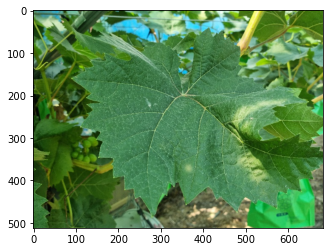

In [7]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# json
sample_json

{'description': {'date': '20210714',
  'image': '10000.jpg',
  'task': 0,
  'width': 682,
  'time': '1019',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': '00',
  'grow': 24,
  'bbox': [{'x': 90.20952277970011,
    'h': 446.1714244521338,
    'y': 41.44761930507497,
    'w': 592.4571438869666}],
  'part': [],
  'risk': 0,
  'crop': 6}}

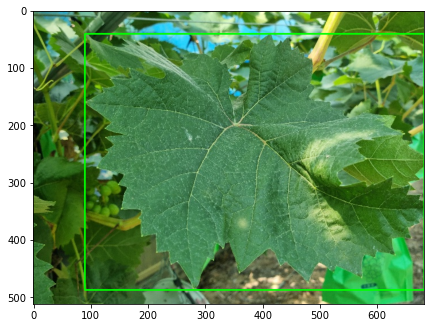

In [9]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

In [16]:
sample_csv.columns

Index(['측정시각', '내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 온도 2 평균',
       '내부 온도 2 최고', '내부 온도 2 최저', '내부 온도 3 평균', '내부 온도 3 최고', '내부 온도 3 최저',
       '내부 온도 4 평균', '내부 온도 4 최고', '내부 온도 4 최저', '내부 습도 1 평균', '내부 습도 1 최고',
       '내부 습도 1 최저', '내부 습도 2 평균', '내부 습도 2 최고', '내부 습도 2 최저', '내부 습도 3 평균',
       '내부 습도 3 최고', '내부 습도 3 최저', '내부 습도 4 평균', '내부 습도 4 최고', '내부 습도 4 최저',
       '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저', '내부 CO2 평균', '내부 CO2 최고',
       '내부 CO2 최저', '외부 풍속 평균', '외부 풍속 최고', '외부 풍속 최저', '내부 EC 1 평균',
       '내부 EC 1 최고', '내부 EC 1 최저', '내부 PH 1 평균', '내부 PH 1 최고', '내부 PH 1 최저',
       '배지 중량 평균', '배지 중량 최고', '배지 중량 최저', '양액 온도 평균', '양액 온도 최고', '양액 온도 최저',
       '외부 풍향 수치', '외부 풍향', '외부 빗물 시간', '외부 누적일사 평균', '양액 급액 누적', '양액 배액 누적'],
      dtype='object')

In [28]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('./sample/sample_data/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|███████████████████████████████████████████████████████████████████████████████| 499/499 [00:03<00:00, 158.85it/s]


{'내부 온도 1 평균': [14.4, 47.3],
 '내부 온도 1 최고': [14.5, 47.6],
 '내부 온도 1 최저': [14.4, 47.0],
 '내부 습도 1 평균': [34.1, 100.0],
 '내부 습도 1 최고': [36.5, 100.0],
 '내부 습도 1 최저': [32.4, 100.0],
 '내부 이슬점 평균': [12.4, 29.9],
 '내부 이슬점 최고': [12.8, 31.9],
 '내부 이슬점 최저': [12.1, 29.1]}

In [29]:
# 제공된 sample data는 파프리카와 시설포도 2종류의 작물만 존재
label_description = {
 '3_00_0': '파프리카_정상',
 '3_a9_1': '파프리카흰가루병_초기',
 '3_a9_2': '파프리카흰가루병_중기',
 '3_a9_3': '파프리카흰가루병_말기',
 '3_a10_1': '파프리카잘록병_초기',
 '3_a10_2': '파프리카잘록병_중기',
 '3_a10_3': '파프리카잘록병_말기',
 '3_b3_1': '칼슘결핍_초기',
 '3_b3_2': '칼슘결핍_중기',
 '3_b3_3': '칼슘결핍_말기',
 '3_b6_1': '다량원소결핍 (N)_초기',
 '3_b6_2': '다량원소결핍 (N)_중기',
 '3_b6_3': '다량원소결핍 (N)_말기',
 '3_b7_1': '다량원소결핍 (P)_초기',
 '3_b7_2': '다량원소결핍 (P)_중기',
 '3_b7_3': '다량원소결핍 (P)_말기',
 '3_b8_1': '다량원소결핍 (K)_초기',
 '3_b8_2': '다량원소결핍 (K)_중기',
 '3_b8_3': '다량원소결핍 (K)_말기',
 '6_00_0': '시설포도_정상',
 '6_a11_1': '시설포도탄저병_초기',
 '6_a11_2': '시설포도탄저병_중기',
 '6_a11_3': '시설포도탄저병_말기',
 '6_a12_1': '시설포도노균병_초기',
 '6_a12_2': '시설포도노균병_중기',
 '6_a12_3': '시설포도노균병_말기',
 '6_b4_1': '일소피해_초기',
 '6_b4_2': '일소피해_중기',
 '6_b4_3': '일소피해_말기',
 '6_b5_1': '축과병_초기',
 '6_b5_2': '축과병_중기',
 '6_b5_3': '축과병_말기',
}

label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [32]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = -1 * 24*6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        json_path = f'{file}/{file_name}.json'
        image_path = f'{file}/{file_name}.jpg'
        
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)

            # MinMax scaling
            for col in self.csv_feature_dict.keys():
                df[col] = df[col] - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            
            # transpose to sequential data
            csv_feature = df[self.csv_feature_dict.keys()].to_numpy()[self.max_len:].T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [33]:
device = torch.device("cuda:0")
batch_size = 256
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 30
vision_pretrain = True
save_path = 'best_model.pt'

In [51]:
data_files = glob('./sample/sample_data/*')

train = data_files[:250]
val = data_files[250:]

In [70]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [71]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

In [72]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n)
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

In [73]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [74]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [76]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [77]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model, save_path)

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './sample/sample_data\\10020/sample_data\\10020.csv'

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()